# Applying zero-suppression to DIOMIRA's output

### Why?
Compression algorithms work well with data showing regular patterns which in our case translates to the large amount of (exact) zeroes in the true waveforms. Due to the introduction of noise to the SiPMs raw waveforms, the output file size has been increased by a factor 50-100 because compression algorithms are no longer efficient. To tackle this issue, the data must be zero-suppressed, getting rid of a large fraction of the SiPMs waveforms that will not be stored.

### How?

The SiPMs noise distributions can be described as a sum of (low-charge) gaussians distributions, each one exponentially smaller. The easiest way to differenciate signal from noise is to place a cut in the SiPMs waveforms so that anything below that level is ignored. Such value (which may be different for every SiPM) must be optimized depending on the conditions and the event signature.

A new function has been introduced to [sensorFunctions.py](../../Core/sensorFunctions.py) to perform the zero-suppression:

In [1]:
def sensor_wise_zero_suppresion(data,thresholds, to_mus=None):
    '''
        takes an array of waveforms, applies the corresponding threshold to
        each row and returns a dictionary with the data frames of the survivors.
    '''
    # If threshold is a single value, transform it into an array
    if not hasattr(thresholds, '__iter__'): thresholds = np.ones( data.shape[0] ) * thresholds

    def zs_df(waveform,threshold):
        '''
            Get the zero-supressed wfms. Return None if it is completely suppresed.
        '''
        t = np.argwhere(waveform>threshold).flatten()
        if not t.any(): return None
        return wf2df( t if to_mus is None else t*to_mus,waveform[t] )

    return { i : df for i,df in enumerate(map(zs_df,data,thresholds)) if not df is None }

##### sensor_wise_zero_suppression function

This function takes an array of waveforms of shape (nsensors,nsamples) and an array of thresholds of shape (1,nsensors) and filters each row with the correspondent threshold. If the zero-suppressed waveform contains anything different than zero it is converted to a pandas data frame and returned within a dictionary that maps each ID to its zero-suppressed waveform.

In [3]:
########### TEST ##############
import wfmFunctions as wfm
import numpy as np
a  = np.arange(6.,18.).reshape(2,6)
th = [9.,14.]
print 'Array:',a,'Thresholds:',th
# This should return a dictionary with:
# 0 mapping to a data frame with [4.,5.] as time_mus and [10.,11.] as ene_pes
# 1 mapping to a data frame with [3.,4.,5.] as time_mus and [15.,16.,17.] as ene_pes
print ''
for sns,df in wfm.sensor_wise_zero_suppresion(a,th).items():
    print 'Sensor ',sns,'\n',df,'\n'

Array: [[  6.   7.   8.   9.  10.  11.]
 [ 12.  13.  14.  15.  16.  17.]] Thresholds: [9.0, 14.0]

Sensor  0 
   ene_pes  time_mus
0     10.0         4
1     11.0         5 

Sensor  1 
   ene_pes  time_mus
0     15.0         3
1     16.0         4
2     17.0         5 



As mentioned before, the cut applied to the waveforms is based on the SiPMs' noise distributions. In order to remove a certain fraction ****c**** of the noise, the number of photoelectrons that covers the distribution to such ****c**** must be found:

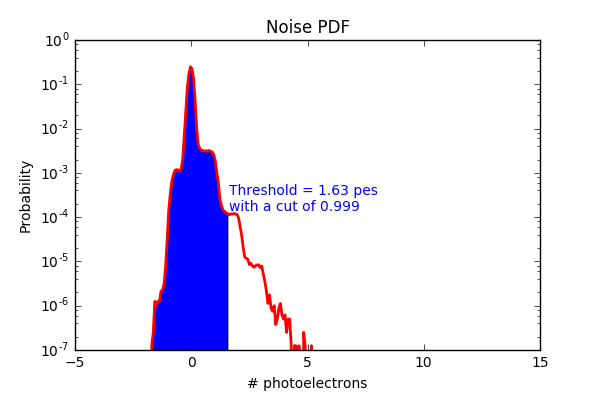

In [4]:
from IPython.display import Image
Image(filename='../../Images/NoiseThreshold.png')

This is done by the new method ComputeThresholds in the [RandomSampling](../../Core/RandomSampling.py) class:

In [5]:
def ComputeThresholds( self, noise_cut = 0.99 ):
    '''
        Find the number of pes at which each noise distribution leaves behind
        the noise_cut fraction of its population.
    '''
    return np.array( [ self.xbins[np.argwhere( probs > noise_cut )[0][0]] for i,probs in enumerate(np.apply_along_axis( np.cumsum, 1, self.probs )) ] )

The cut to be performed is an input to the ComputeThresholds method and can be changed by the user. For this reason, a new configuration parameter has been introduced, which needs to be written in the csv file:
````
NOISE_CUT_FRACTION = CFP['NOISE_CUT_FRACTION']
````


### Storage of waveforms
Because waveforms are no longer equal-sized objects, they cannot be stored in a earray and a table must be used. The table description is the same as for true waveforms so it has been generalized in [Nh5.py](../../Core/Nh5.py):

In [6]:
class SENSOR_WF(tables.IsDescription): ### FROM PMT_TWF AND SIPM_TWF
    """
    Describes a true waveform (zero supressed)
    """
    event = tables.UInt32Col(pos=0)
    ID = tables.UInt32Col(pos=1)
    time_mus = tables.Float32Col(pos=2)
    ene_pes = tables.Float32Col(pos=3)

NameError: name 'tables' is not defined

The function used to store waveforms has been generalized in the same way:

In [7]:
def store_wf(event, table, WF):
    """
    Store WF in table
    """
    row = table.row
    for isens,wf in WF.items():
        for t,e in zip(wf.time_mus, wf.ene_pes):
            row['event'] = event
            row['ID'] = isens
            row['time_mus'] = t
            row['ene_pes'] = e
            row.append()
    table.flush()

Other changes in **DIOMIRA** are very localized:
1) Before opening the outputfile the thresholds are computed:
```
sipms_noise_thresholds_ = sipms_noise_sampler_.ComputeThresholds(NOISE_CUT_FRACTION)
```
2) The storage of SiPMs' RWF is declared as a table:
````
sipm_rwf_table = h5out.create_table( rgroup, "sipmrwf", SENSOR_WF, "Store for SiPMs RWF",
                                     tables.Filters(complib=CLIB, complevel=CLEVEL) )
````
3) Before storing the waveforms, they are zero-suppressed:
````
zs_wfms = sns.sensor_wise_zero_suppresion(dataSiPM,thresholds)
store_wf( i, sipm_rwf_table, zs_wfms )
````

## Running DIOMIRA

**The execution time has increased by 25%, probably because of the zero-suppression algorithm. However the size of the output file is ~8 smaller.**

# DIOMIRA COMES BACK TO NON-ZS!!!!

In [1]:
%cd ../../Cities/

/Users/Gonzalo/github/IC/Cities


In [3]:
run DIOMIRA.py -c ../Config/DIOMIRA_default.csv

Debug level = INFO
input path =/Users/Gonzalo/github/IC/data/; output path = /Users/Gonzalo/github/IC/data/; file_in =in0.h5 file_out =out0.h5
path to database = /Users/Gonzalo/github/IC/Database/
first event = 0 last event = 10 nof events requested = 10 
Compression library = zlib Compression level = 1 
nof PMTs = 12 nof  SiPMs = 1789 nof events in input DST = 100 
lof SiPM WF = 800000 lof PMT WF (MC) = 800 lof PMT WF (FEE) = 32000
Initializing NoiseSampler... OK
-->event number =0


/Applications/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
DIOMIRA has run over 9 events in 16.1233549118 seconds
Leaving Diomira. Safe travels!


In [4]:
%ls -lah ../data/

total 53376
drwxr-xr-x   4 Gonzalo  staff   136B Oct 14 17:35 ./
drwxr-xr-x  21 Gonzalo  staff   714B Oct 14 17:34 ../
-rw-r--r--@  1 Gonzalo  staff    24M Oct 14 17:35 in0.h5
-rw-r--r--   1 Gonzalo  staff   2.2M Oct 14 17:35 out0.h5


## Data check

In [5]:
import mplFunctions as mpl
import wfmFunctions as wfm
import sensorFunctions as snf
import tblFunctions as tbl
import numpy as np
import tables as tb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.figure(figsize=(45,60))

In [6]:
h5f = tb.open_file('/Users/Gonzalo/github/IC/data/out0.h5')
print(h5f)

/Users/Gonzalo/github/IC/data/out0.h5 (File) ''
Last modif.: 'Fri Oct 14 17:35:21 2016'
Object Tree: 
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(806,), zlib(1)) ''
/RD (Group) ''
/RD/pmtrwf (EArray(10, 12, 32000), shuffle, zlib(1)) ''
/RD/sipmrwf (EArray(10, 1789, 800), shuffle, zlib(1)) ''
/Sensors (Group) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(141,), shuffle, zlib(1)) 'Store for PMTs TWF'
/TWF/SiPM (Table(1007,), shuffle, zlib(1)) 'Store for SiPMs TWF'



In [7]:
def get_vectors(h5f):
    """
    input: file pointer
    returns: data vectors
    """
    pmttwf = h5f.root.TWF.PMT
    sipmtwf = h5f.root.TWF.SiPM
    pmtrwf = h5f.root.RD.pmtrwf
    sipmrwf = h5f.root.RD.sipmrwf
    geom_t = h5f.root.Detector.DetectorGeometry
    pmt_t = h5f.root.Sensors.DataPMT
    sipm_t = h5f.root.Sensors.DataSiPM
    gdf = snf.read_data_geom(geom_t)
    pmtdf = snf.read_data_sensors(pmt_t)
    sipmdf = snf.read_data_sensors(sipm_t)
    return pmttwf,sipmtwf,pmtrwf,sipmrwf,pmtdf,sipmdf,gdf

In [8]:
pmttwf,sipmtwf,pmtrwf,sipmrwf,pmtdf,sipmdf,gdf = get_vectors(h5f)

SiPM with greatest peak is at index 331 with ID 6011.0


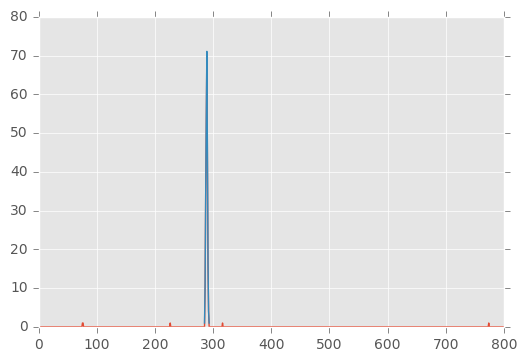

In [9]:
mpl.plot_best(sipmrwf,sipmtwf,sipmdf,0)

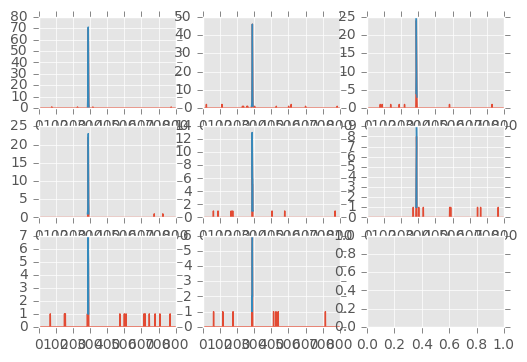

In [10]:
mpl.plot_best_group(sipmrwf,sipmtwf,0)

In [12]:
from RandomSampling import NoiseSampler as SiPMsNoiseSampler
ns = SiPMsNoiseSampler('../Database/NoiseSiPM_NEW.dat',{ j:i for i,j in enumerate([1000*i+1000+j for i in range(28) for j in range(64)]) if not j in [14010,15047,25049]})

Initializing NoiseSampler... OK


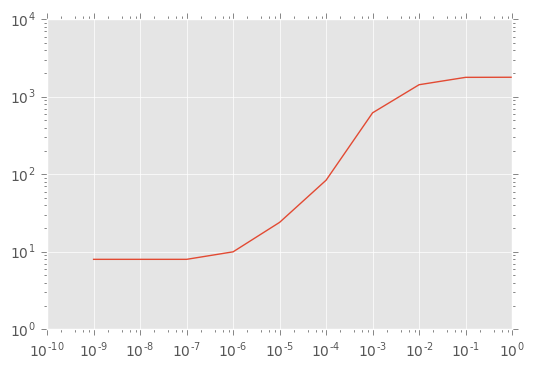

In [13]:
cuts = np.array([1 - 0.1**i for i in range(10)])
nsens = []
for th in map( ns.ComputeThresholds, cuts):
    zs = wfm.sensor_wise_zero_suppresion(sipmrwf[0],th)
    nsens.append(len(zs))
plt.xscale('log')
plt.yscale('log')
plt.plot(1-cuts,nsens)

In [ ]:
####